# Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)

In [13]:
# Reading the dataset
df = pd.read_csv('../data/fps-dataset-clean.csv', low_memory=False)
df.head()

,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,Dataset,FPS
0,Intel Core i7-920,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,0,45.0,130.0,2933.0,AMD Radeon RX 480,GCN 4.0,256000.0,1120.0,1266.0,PCIe 3.0 x16,0.000232,12,5834000.0,256.0,8000.0,GDDR5,2,4.6,40510.0,14.0,32.0,6.4,2304.0,144.0,182300.0,5700.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,userbenchmark,70.0
1,Intel Core i7-920,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,0,45.0,130.0,2933.0,AMD Radeon RX 480,GCN 4.0,256000.0,1120.0,1266.0,PCIe 3.0 x16,0.000232,12,5834000.0,256.0,8000.0,GDDR5,2,4.6,40510.0,14.0,32.0,6.4,2304.0,144.0,182300.0,5700.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,userbenchmark,230.0
2,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,userbenchmark,250.0
3,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,NVIDIA GeForce GTX 1080 11Gbps,Pascal,352300.0,1607.0,1733.0,PCIe 3.0 x16,0.000314,12,8873000.0,256.0,8000.0,GDDR5X,1.2,4.6,110900.0,16.0,64.0,6.4,2560.0,160.0,277300.0,7200.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,userbenchmark,300.0
4,Intel Core i5-4690,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,0,22.0,84.0,3800.0,AMD Radeon R7 260X,GCN 2.0,104000.0,1100.0,1100.0,PCIe 3.0 x16,0.000160,12,1971000.0,128.0,2000.0,GDDR5,2,4.6,17600.0,28.0,16.0,6.3,896.0,56.0,61600.0,2080.0,1.2.131,counterStrikeGlobalOffensive,1080.0,low,userbenchmark,200.0


In [14]:
df.drop(columns=['Dataset'], inplace=True)

In [15]:
# View the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194700 entries, 0 to 194699
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CpuName                  194700 non-null  object 
 1   CpuNumberOfCores         194700 non-null  float64
 2   CpuNumberOfThreads       194700 non-null  float64
 3   CpuBaseClock             194700 non-null  float64
 4   CpuCacheL1               194700 non-null  float64
 5   CpuCacheL2               194700 non-null  float64
 6   CpuCacheL3               194700 non-null  float64
 7   CpuFrequency             194700 non-null  float64
 8   CpuMultiplier            194700 non-null  float64
 9   CpuMultiplierUnlocked    194700 non-null  int64  
 10  CpuProcessSize           194700 non-null  float64
 11  CpuTDP                   194700 non-null  float64
 12  CpuTurboClock            194700 non-null  float64
 13  GpuName                  194700 non-null  object 
 14  GpuA

In [16]:
# Visualize the distribution of the target variable
def create_boxplots(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    num_cols = len(columns)
    num_rows = (num_cols + 2) // 3
    plt.figure(figsize=(15, 5 * num_rows))
    for i, col in enumerate(reversed(columns)):
        plt.subplot(num_rows, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot de {col}')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

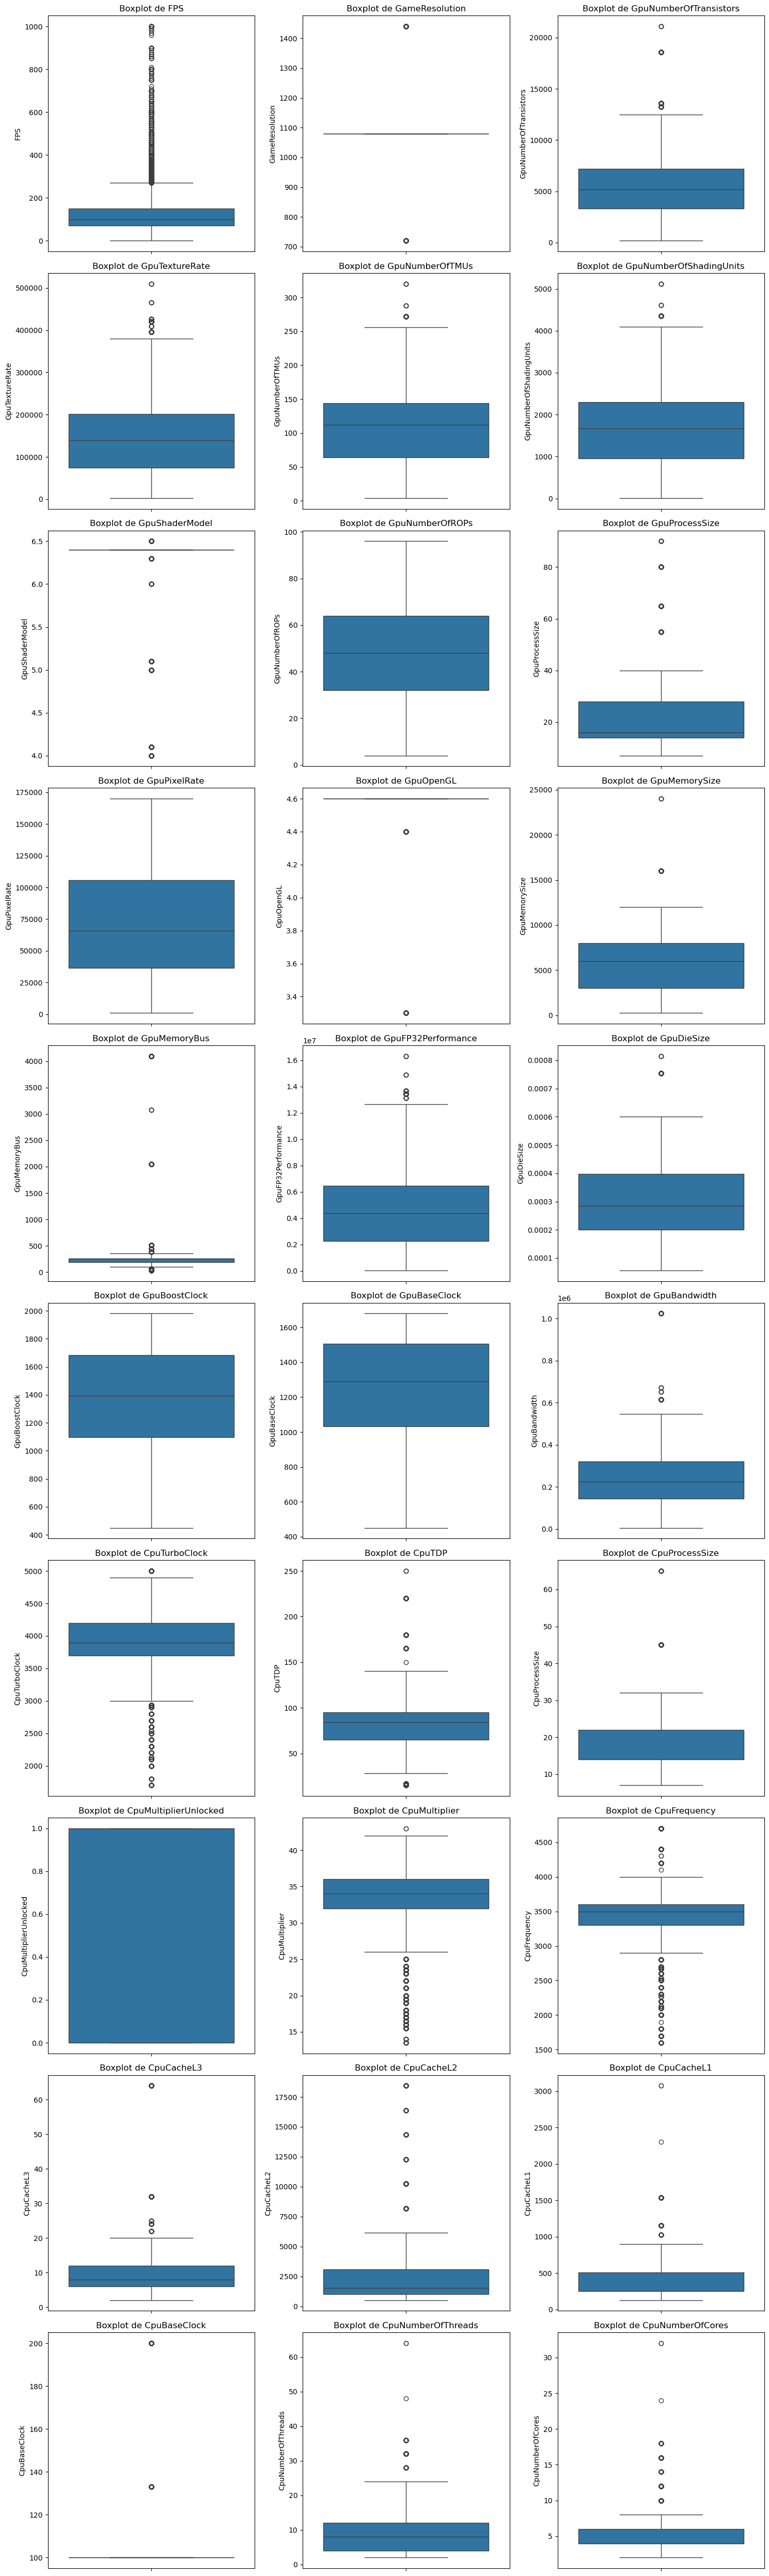

In [17]:
# Create boxplots for all numerical columns
create_boxplots(df)

In [18]:
# Separating the features in nominal and ordinal categories
nominal = ['CpuName', 'GpuName', 'GpuArchitecture', 'GpuBus nterface', 'GameName']
ordinal = ['GpuDirectX', 'GpuMemoryType', 'GpuOpenCL', 'GpuOpenGL', 'GpuShaderModel', 'GpuVulkan', 'GameSetting']

In [19]:
# Mapping the ordinal columns
mappings = [
    {
        'col': 'GpuDirectX',
        'mapping': {
            '12': 0,
            '12 Ultimate': 1,
        }
    },
    {
        'col': 'GpuMemoryType',
        'mapping': {
            'GDDR3': 0,
            'DDR3': 1,
            'GDDR5': 2,
            'GDDR5X': 3,
            'GDDR6': 4,
            'HBM': 5,
            'HBM2': 6,
        }
    },
    {
        'col': 'GpuOpenCL',
        'mapping': {
            '1.2': 0,
            '2': 1,
        }
    },
    {
        'col': 'GpuOpenGL',
        'mapping': {
            '4.6': 0,
        }
    },
    {
        'col': 'GpuShaderModel',
        'mapping': {
            '5': 0,
            '5.1': 1,
            '6': 2,
            '6.3': 3,
            '6.4': 4,
            '6.5': 5,
        }
    },
    {
        'col': 'GpuVulkan',
        'mapping': {
            '1.1.125': 0,
            '1.1.126': 1,
            '1.2.131': 2,
        }
    },
    {
        'col': 'GameSetting',
        'mapping': {
            'low': 0,
            'med': 1,
            'high': 2,
            'max': 3,
        }
    }
]

In [20]:
# One-hot encoding the nominal columns and ordinal encoding the ordinal columns
onehotenc = OneHotEncoder(cols = nominal)
ordinalenc = OrdinalEncoder(cols = ordinal, mapping = mappings)

In [ ]:
# Pipeline
nominal_transformer = Pipeline(
    steps=[
        ('nominal', onehotenc)
    ]
)
ordinal_transformer = Pipeline(
    steps=[
        ('ordinal', ordinalenc)
    ]
)

mapper = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal),
        ('ordinal', ordinal_transformer, ordinal)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('mapper', mapper),
        ('scaler', StandardScaler())
    ]
)

In [26]:
X = df.drop(columns=['FPS'])
y = df['FPS']

X.shape, y.shape

((194700, 39), (194700,))

In [27]:
encoded = pipeline.fit_transform(X)
data = pd.DataFrame(encoded, columns=pipeline.named_steps['mapper'].get_feature_names_out())
data.head()

,nominal__CpuName_1,nominal__CpuName_2,nominal__CpuName_3,nominal__CpuName_4,nominal__CpuName_5,nominal__CpuName_6,nominal__CpuName_7,nominal__CpuName_8,nominal__CpuName_9,nominal__CpuName_10,nominal__CpuName_11,nominal__CpuName_12,nominal__CpuName_13,nominal__CpuName_14,nominal__CpuName_15,nominal__CpuName_16,nominal__CpuName_17,nominal__CpuName_18,nominal__CpuName_19,nominal__CpuName_20,nominal__CpuName_21,nominal__CpuName_22,nominal__CpuName_23,nominal__CpuName_24,nominal__CpuName_25,nominal__CpuName_26,nominal__CpuName_27,nominal__CpuName_28,nominal__CpuName_29,nominal__CpuName_30,nominal__CpuName_31,nominal__CpuName_32,nominal__CpuName_33,nominal__CpuName_34,nominal__CpuName_35,nominal__CpuName_36,nominal__CpuName_37,nominal__CpuName_38,nominal__CpuName_39,nominal__CpuName_40,nominal__CpuName_41,nominal__CpuName_42,nominal__CpuName_43,nominal__CpuName_44,nominal__CpuName_45,nominal__CpuName_46,nominal__CpuName_47,nominal__CpuName_48,nominal__CpuName_49,nominal__CpuName_50,nominal__CpuName_51,nominal__CpuName_52,nominal__CpuName_53,nominal__CpuName_54,nominal__CpuName_55,nominal__CpuName_56,nominal__CpuName_57,nominal__CpuName_58,nominal__CpuName_59,nominal__CpuName_60,nominal__CpuName_61,nominal__CpuName_62,nominal__CpuName_63,nominal__CpuName_64,nominal__CpuName_65,nominal__CpuName_66,nominal__CpuName_67,nominal__CpuName_68,nominal__CpuName_69,nominal__CpuName_70,nominal__CpuName_71,nominal__CpuName_72,nominal__CpuName_73,nominal__CpuName_74,nominal__CpuName_75,nominal__CpuName_76,nominal__CpuName_77,nominal__CpuName_78,nominal__CpuName_79,nominal__CpuName_80,nominal__CpuName_81,nominal__CpuName_82,nominal__CpuName_83,nominal__CpuName_84,nominal__CpuName_85,nominal__CpuName_86,nominal__CpuName_87,nominal__CpuName_88,nominal__CpuName_89,nominal__CpuName_90,nominal__CpuName_91,nominal__CpuName_92,nominal__CpuName_93,nominal__CpuName_94,nominal__CpuName_95,nominal__CpuName_96,nominal__CpuName_97,nominal__CpuName_98,nominal__CpuName_99,nominal__CpuName_100,nominal__CpuName_101,nominal__CpuName_102,nominal__CpuName_103,nominal__CpuName_104,nominal__CpuName_105,nominal__CpuName_106,nominal__CpuName_107,nominal__CpuName_108,nominal__CpuName_109,nominal__CpuName_110,nominal__CpuName_111,nominal__CpuName_112,nominal__CpuName_113,nominal__CpuName_114,nominal__CpuName_115,nominal__CpuName_116,nominal__CpuName_117,nominal__CpuName_118,nominal__CpuName_119,nominal__CpuName_120,nominal__CpuName_121,nominal__CpuName_122,nominal__CpuName_123,nominal__CpuName_124,nominal__CpuName_125,nominal__CpuName_126,nominal__CpuName_127,nominal__CpuName_128,nominal__CpuName_129,nominal__CpuName_130,nominal__CpuName_131,nominal__CpuName_132,nominal__CpuName_133,nominal__CpuName_134,nominal__CpuName_135,nominal__CpuName_136,nominal__CpuName_137,nominal__CpuName_138,nominal__CpuName_139,nominal__CpuName_140,nominal__CpuName_141,nominal__CpuName_142,nominal__CpuName_143,nominal__CpuName_144,nominal__CpuName_145,nominal__CpuName_146,nominal__CpuName_147,nominal__CpuName_148,nominal__CpuName_149,nominal__CpuName_150,nominal__CpuName_151,nominal__CpuName_152,nominal__CpuName_153,nominal__CpuName_154,nominal__CpuName_155,nominal__CpuName_156,nominal__CpuName_157,nominal__CpuName_158,nominal__CpuName_159,nominal__CpuName_160,nominal__CpuName_161,nominal__CpuName_162,nominal__CpuName_163,nominal__CpuName_164,nominal__CpuName_165,nominal__CpuName_166,nominal__CpuName_167,nominal__CpuName_168,nominal__CpuName_169,nominal__CpuName_170,nominal__CpuName_171,nominal__CpuName_172,nominal__CpuName_173,nominal__CpuName_174,nominal__CpuName_175,nominal__CpuName_176,nominal__CpuName_177,nominal__CpuName_178,nominal__CpuName_179,nominal__CpuName_180,nominal__CpuName_181,nominal__CpuName_182,nominal__CpuName_183,nominal__CpuName_184,nominal__CpuName_185,nominal__CpuName_186,nominal__CpuName_187,nominal__CpuName_188,nominal__CpuName_189,nominal__CpuName_190,nominal__CpuName_191,nominal__CpuName_192,nominal__CpuName_193,nominal__CpuName_194,nominal__CpuName_195,nominal__Cpu

In [28]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155760, 781), (38940, 781), (155760,), (38940,))

In [31]:
# train random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [32]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

MSE: 3899.8916944973626


In [34]:
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 62.44911283995444


PCA is used in this case to reduce dimensionality while retaining the most important variance in the dataset. Given the high number of features related to CPU and GPU specifications, PCA helps to simplify the data without losing significant information, making it easier to visualize and analyze. By transforming the original correlated features into a smaller set of uncorrelated components, PCA also helps mitigate the risk of overfitting in machine learning models and improves computational efficiency.

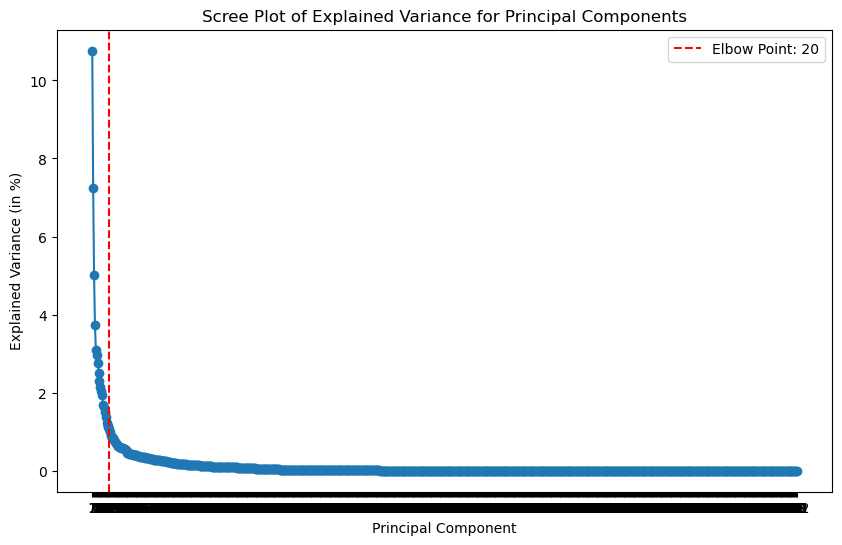

In [25]:
pca = PCA()
pca_results = pca.fit_transform(data)
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.01) + 1 

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.title('Scree Plot of Explained Variance for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (in %)')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.show()

In [52]:
# Create a PCA object with 2 components
pca = PCA(n_components=20) 
principal_components = pca.fit_transform(data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-0.665921,-0.007851,-0.043836,-0.702112,0.084292,1.185481,-0.026347,-0.365198,-0.158892,0.681438,0.029188,0.292266,0.011553,0.158011,0.237165,-0.113692,0.188336,-0.007509,-0.017301,0.050845
1,-0.660901,-0.009310,-0.045240,-0.701220,0.079378,1.197448,-0.021285,-0.361575,-0.153760,0.683037,0.031970,0.293865,0.013077,0.150073,0.245892,-0.114210,0.187758,-0.014794,-0.021123,0.048516
2,0.486254,0.682351,-0.480478,0.187617,-0.474060,0.999461,-0.001518,-0.363833,0.049873,0.348988,0.032858,-0.128337,-0.078779,0.037137,0.175522,-0.356056,-0.198646,-0.313995,0.605359,-0.135886
3,0.487822,0.681895,-0.480917,0.187896,-0.475595,1.003201,0.000064,-0.362701,0.051477,0.349487,0.033727,-0.127837,-0.078303,0.034656,0.178250,-0.356218,-0.198827,-0.316272,0.604165,-0.136614
4,-1.047279,0.188958,-0.300258,-0.150255,-0.561839,0.776483,0.147622,-0.042517,-0.032606,0.087216,0.067864,0.004424,-0.040197,0.037742,0.127526,0.274165,-0.372683,-0.024583,0.009463,0.073718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187178,-0.037082,-0.460744,0.395373,-0.594253,0.887881,0.224478,0.068094,0.176294,0.027911,-0.273448,-0.051655,0.181872,-0.009217,0.080745,-0.013822,0.072817,0.020839,0.116351,0.076671,-0.037129
187179,-0.054243,-0.449314,0.410963,-0.577637,0.887228,0.218085,0.067639,0.151968,0.027549,-0.245621,-0.055549,0.222716,-0.007494,0.092768,-0.002274,0.090997,0.013143,0.105720,0.096025,-0.005283
187180,-0.069777,-0.434922,0.412727,-0.566521,0.894212,0.219480,0.066612,0.140960,0.023034,-0.240840,-0.055397,0.220324,-0.006763,0.092877,-0.005526,0.098111,0.006023,0.112933,0.090072,-0.001274
187181,-0.074538,-0.438255,0.423173,-0.608066,0.897894,0.225697,0.063681,0.173521,0.033522,-0.256133,-0.055548,0.235049,0.003473,0.103680,0.004162,0.103916,0.041130,0.101674,0.067786,-0.170878


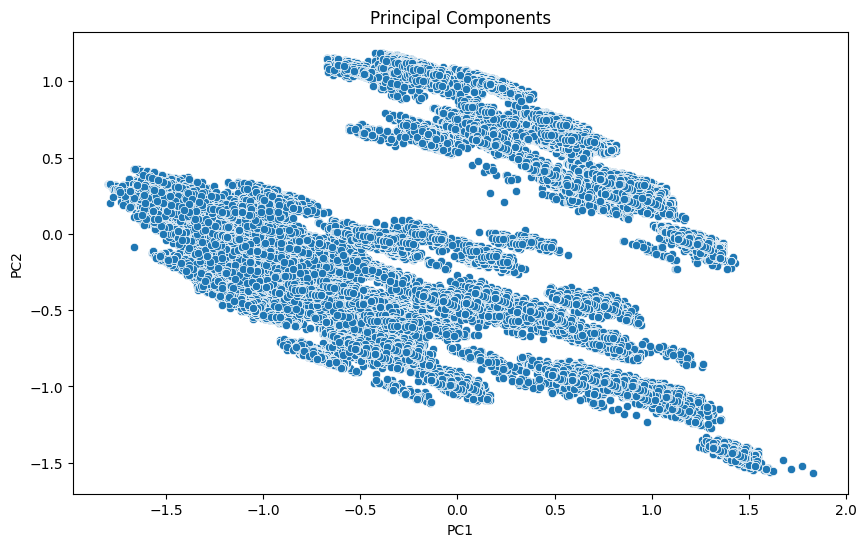

In [38]:
# Create a scatter plot to visualize the observations in the 2D PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('Principal Components')
plt.show()

In [39]:
# Verify quantity of columns and rows
df.shape

(187183, 40)

In [40]:
# Verify that PCA has 2 columns
pca_df.shape

(187183, 2)